In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

## Генерация фичей

In [5]:
# df = pd.read_csv('data_for_feature_generation.csv')
df = pd.read_csv('sber_data.csv')

In [6]:
df

,open,high,close,low,time,volume
0,215,215,215,215,2023-04-04 14:23:00+00:00,1067
1,215,215,215,215,2023-04-04 14:24:00+00:00,6009
2,215,215,215,215,2023-04-04 14:25:00+00:00,11561
3,215,215,215,215,2023-04-04 14:26:00+00:00,4514
4,215,215,215,215,2023-04-04 14:27:00+00:00,10858
...,...,...,...,...,...,...
411449,269,269,269,269,2024-09-25 14:19:00+00:00,6587
411450,269,269,269,269,2024-09-25 14:20:00+00:00,17085
411451,269,269,269,269,2024-09-25 14:21:00+00:00,5925
411452,269,269,269,269,2024-09-25 14:22:00+00:00,3549


In [7]:
df['time'] = pd.to_datetime(df['time'])

<Axes: >

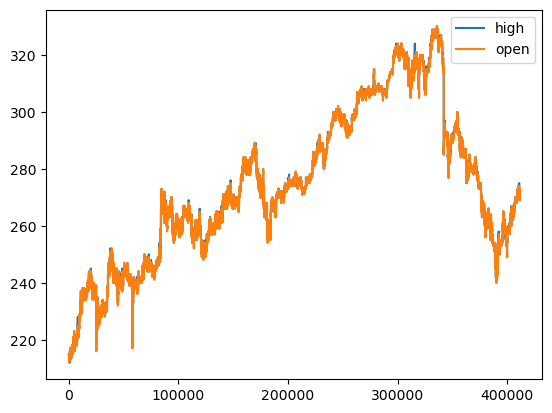

In [8]:
df[['high', 'open']].plot()

In [10]:
df['time'].min(), df['time'].max()

(Timestamp('2023-04-04 14:23:00+0000', tz='UTC'),
 Timestamp('2024-09-25 14:23:00+0000', tz='UTC'))

In [11]:
df.dtypes

open                    int64
high                    int64
close                   int64
low                     int64
time      datetime64[ns, UTC]
volume                  int64
dtype: object

In [ ]:
df['year']=df['time'].dt.strftime('%Y')
df['month']=df['time'].dt.strftime('%m')
df['day']=df['time'].dt.strftime('%d')
df['year_month']=df['time'].dt.strftime('%Y_%m')
df['hour']=df['time'].dt.strftime('%H')
df['minute']=df['time'].dt.strftime('%M')

## BaseLine

In [25]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
from matplotlib import  pyplot as plt

# Функция для добавления целевой переменной (таргета)
def add_target(df):
    df['close_next_hour'] = df['close'].shift(-15)
    df['target'] = (df['close_next_hour'] > df['close']).astype(int)
    df = df.dropna(subset=['close_next_hour'])
    
    return df

# Первый метод: фильтрация строк, где таргет не определён (например, NaN в close_next_hour)
def filter_invalid_targets(df):
    # Удаляем строки, где close_next_hour или target равен NaN
    return df.dropna(subset=['close_next_hour', 'target'])



## Трендовые фичи и тех. индикаторы

In [26]:
def create_trend_features(df, features, lag_periods):
    """
    Добавляет классические финансовые признаки: отношение к предыдущим периодам, логарифмические изменения и индикаторы трендов.
    
    df: DataFrame с исходными данными
    features: список признаков, для которых необходимо добавить индикаторы
    lag_periods: сколько периодов назад учитывать для расчетов
    
    Возвращает:
    - обновленный DataFrame с новыми фичами
    - список новых колонок, которые можно использовать как признаки
    """
    df = df.copy()  # Работаем с копией DataFrame
    new_columns = []  # Список для хранения новых колонок
    
    for feature in features:
        # Отношение текущего значения к предыдущему (лаг = 1)
        df[f'{feature}_ratio_1'] = df[feature] / df[feature].shift(1)
        new_columns.append(f'{feature}_ratio_1')
        
        # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
        df[f'{feature}_log_diff_1'] = np.log(df[feature] / df[feature].shift(1))
        new_columns.append(f'{feature}_log_diff_1')
        
        # Momentum (разница между текущим значением и значением N периодов назад)
        df[f'{feature}_momentum_{lag_periods}'] = df[feature] - df[feature].shift(lag_periods)
        new_columns.append(f'{feature}_momentum_{lag_periods}')
        
        # Rate of Change (ROC): процентное изменение за N периодов
        df[f'{feature}_roc_{lag_periods}'] = (df[feature] - df[feature].shift(lag_periods)) / df[feature].shift(lag_periods) * 100
        new_columns.append(f'{feature}_roc_{lag_periods}')
        
        # Exponential Moving Average (EMA) с периодом N
        df[f'{feature}_ema_{lag_periods}'] = df[feature].ewm(span=lag_periods, adjust=False).mean()
        new_columns.append(f'{feature}_ema_{lag_periods}')
    
    # Удаление строк с NaN значениями, которые появились из-за сдвигов
    df = df.dropna()
    
    return df, new_columns


In [28]:
def create_macd(df, feature, short_window=12, long_window=26):
    """
    Добавляет индикатор MACD (разница между краткосрочным и долгосрочным EMA).
    
    df: DataFrame с исходными данными
    feature: признак, для которого необходимо рассчитать MACD
    short_window: окно для краткосрочного EMA (по умолчанию 12)
    long_window: окно для долгосрочного EMA (по умолчанию 26)
    
    Возвращает:
    - обновленный DataFrame с MACD
    - название новой колонки с MACD
    """
    df = df.copy()
    
    # Рассчитываем краткосрочное и долгосрочное EMA
    ema_short = df[feature].ewm(span=short_window, adjust=False).mean()
    ema_long = df[feature].ewm(span=long_window, adjust=False).mean()
    
    # Разница между краткосрочным и долгосрочным EMA (MACD)
    df[f'{feature}_macd'] = ema_short - ema_long
    
    return df, f'{feature}_macd'

In [30]:
# Добавляем целевую переменную (таргет)
data = filter_invalid_targets(add_target(df))

# Параметры для создания трендовых признаков
lag_periods = 3  # Например, 3 периода назад
features_to_trend = ['open', 'high', 'low', 'close', 'volume']

# Создаем трендовые признаки
data_with_trend, new_trend_features = create_trend_features(data, features_to_trend, lag_periods)

# Добавляем MACD для признака 'close'
data_with_trend, macd_column = create_macd(data_with_trend, 'close')

# Добавляем название колонки с MACD в список новых фичей
new_trend_features.append(macd_column)

In [31]:
len(new_trend_features)

26

In [36]:
new_trend_features

['open_ratio_1',
 'open_log_diff_1',
 'open_momentum_3',
 'open_roc_3',
 'open_ema_3',
 'high_ratio_1',
 'high_log_diff_1',
 'high_momentum_3',
 'high_roc_3',
 'high_ema_3',
 'low_ratio_1',
 'low_log_diff_1',
 'low_momentum_3',
 'low_roc_3',
 'low_ema_3',
 'close_ratio_1',
 'close_log_diff_1',
 'close_momentum_3',
 'close_roc_3',
 'close_ema_3',
 'volume_ratio_1',
 'volume_log_diff_1',
 'volume_momentum_3',
 'volume_roc_3',
 'volume_ema_3',
 'close_macd']

In [34]:
data = data_with_trend[new_trend_features + ['target', 'time']]
data

,open_ratio_1,open_log_diff_1,open_momentum_3,open_roc_3,open_ema_3,high_ratio_1,high_log_diff_1,high_momentum_3,high_roc_3,high_ema_3,...,close_roc_3,close_ema_3,volume_ratio_1,volume_log_diff_1,volume_momentum_3,volume_roc_3,volume_ema_3,close_macd,target,time
3,1.0,0.0,0.0,0.000000,215.000000,1.0,0.0,0.0,0.000000,215.000000,...,0.000000,215.000000,0.390451,-0.940454,3447.0,323.055295,6031.750000,0.000000,0,2023-04-04 14:26:00+00:00
4,1.0,0.0,0.0,0.000000,215.000000,1.0,0.0,0.0,0.000000,215.000000,...,0.000000,215.000000,2.405405,0.877718,4849.0,80.695623,8444.875000,0.000000,0,2023-04-04 14:27:00+00:00
5,1.0,0.0,0.0,0.000000,215.000000,1.0,0.0,0.0,0.000000,215.000000,...,0.000000,215.000000,1.160987,0.149271,1045.0,9.039010,10525.437500,0.000000,0,2023-04-04 14:28:00+00:00
6,1.0,0.0,0.0,0.000000,215.000000,1.0,0.0,0.0,0.000000,215.000000,...,0.000000,215.000000,0.517928,-0.657919,2015.0,44.638901,8527.218750,0.000000,0,2023-04-04 14:29:00+00:00
7,1.0,0.0,0.0,0.000000,215.000000,1.0,0.0,0.0,0.000000,215.000000,...,0.000000,215.000000,0.395926,-0.926528,-8273.0,-76.192669,5556.109375,0.000000,0,2023-04-04 14:30:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411434,1.0,0.0,-1.0,-0.369004,270.249998,1.0,0.0,-1.0,-0.369004,270.250000,...,-0.369004,270.121093,1.626175,0.486231,7127.0,348.849731,6666.577856,-0.189650,0,2024-09-25 14:04:00+00:00
411435,1.0,0.0,-1.0,-0.369004,270.124999,1.0,0.0,-1.0,-0.369004,270.125000,...,0.000000,270.060546,0.978517,-0.021717,6685.0,292.176573,7819.788928,-0.219607,0,2024-09-25 14:05:00+00:00
411436,1.0,0.0,0.0,0.000000,270.062500,1.0,0.0,0.0,0.000000,270.062500,...,0.000000,270.030273,1.749248,0.559186,10057.0,178.347225,11757.894464,-0.240575,0,2024-09-25 14:06:00+00:00
411437,1.0,0.0,0.0,0.000000,270.031250,1.0,0.0,0.0,0.000000,270.031250,...,0.000000,270.015137,0.621751,-0.475216,589.0,6.423119,10758.447232,-0.254262,0,2024-09-25 14:07:00+00:00


## Samples split

In [38]:
# Преобразуем столбец времени к формату datetime (если еще не сделано)
data['time'] = pd.to_datetime(data['time'])

# Определяем дату начала тестовой выборки (последний месяц)
test_start_date = data['time'].max() - pd.DateOffset(months=1)

# Определяем дату начала валидационной выборки (предпоследний месяц)
val_start_date = data['time'].max() - pd.DateOffset(months=2)

# Разделение данных на тренировочную, валидационную и тестовую выборки по времени
train_data = data[data['time'] < val_start_date]  # все, что до предпоследнего месяца
val_data = data[(data['time'] >= val_start_date) & (data['time'] < test_start_date)]  # предпоследний месяц
test_data = data[data['time'] >= test_start_date]  # последний месяц

# Признаки, которые будем использовать
features = new_trend_features  # Убедись, что 'new_trend_features' определены

# Разделение на признаки (X) и целевую переменную (y) для каждой выборки
X_train = train_data[new_trend_features]
y_train = train_data['target']

X_val = val_data[new_trend_features]
y_val = val_data['target']

X_test = test_data[new_trend_features]
y_test = test_data['target']

# Проверим размерности, если нужно
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 353810, Val size: 27931, Test size: 29695


## MODELS

In [46]:
from IPython.display import display, Markdown

In [48]:
def calculate_metrics_table(y_true, y_pred_prob, thresholds=[0.5, 0.6, 0.7, 0.8]):
    metrics_table = []
    
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        metrics = {
            'Cutoff': threshold,
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1-Score': f1_score(y_true, y_pred)
        }
        metrics_table.append(metrics)
    
    # Преобразуем список словарей в DataFrame для удобного вывода
    return pd.DataFrame(metrics_table)*100

In [50]:
# Выводим ROC AUC и метрики для всех выборок
def display_metrics_set(name, y_true, y_pred_prob):
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    print(f"\n=== Метрики для {name} выборки ===")
    print(f"ROC AUC: {roc_auc:.4f}")
    metrics_table = calculate_metrics_table(y_true, y_pred_prob)
    print(metrics_table)


### Logistic regression with MinMaxScaler

In [52]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# 1. Применение MinMaxScaler к тренировочной, валидационной и тестовой выборкам
scaler = MinMaxScaler()

# Обучаем скейлер на тренировочной выборке и трансформируем её
X_train_scaled = scaler.fit_transform(X_train)

# Трансформируем валидационную и тестовую выборки
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [56]:
# 2. Обучение модели логистической регрессии на тренировочной выборке
model = LogisticRegression(solver='liblinear')  # Используем liblinear для бинарной классификации
model.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

##### Logistic Regression: Топ 3 параметра для тюнинга
- **solver**: Метод оптимизации. Популярные значения:
  - `'liblinear'` (по умолчанию для небольших датасетов)
  - `'lbfgs'` (подходит для многоклассовых задач)
  - `'saga'` (подходит для больших датасетов и разреженных данных)
- **C**: Инверсия регуляризации. Меньшие значения C увеличивают регуляризацию, что помогает избежать переобучения. Например, `C=1.0` (по умолчанию), `C=0.01` — более сильная регуляризация.
- **max_iter**: Максимальное количество итераций для оптимизации. Увеличьте, если модель не сходится. Например, `max_iter=1000`.

In [58]:
# 3. Предсказания на валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
y_val_pred_prob = model.predict_proba(X_val_scaled)[:, 1]
y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

In [64]:
# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [66]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7636


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,64.635692,12.409025,86.841808,20.820790
1,60.0,66.117948,8.386888,86.628416,14.885579
2,70.0,68.313725,5.297302,86.454312,9.832179
3,80.0,73.074205,2.096215,86.242899,4.075519


In [67]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7762


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,61.068702,2.348107,87.905911,4.522329
1,60.0,60.526316,1.350161,87.859368,2.641401
2,70.0,69.230769,1.056648,87.873689,2.081526
3,80.0,65.625000,0.616378,87.837886,1.221285


In [68]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.7170


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,41.035857,2.429245,85.569961,4.586952
1,60.0,33.823529,1.084906,85.573329,2.102377
2,70.0,35.937500,0.542453,85.660886,1.068773
3,80.0,42.857143,0.353774,85.704664,0.701754


In [71]:
# 5. Выводим топ-5 самых значимых факторов по весам
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
})

# Сортируем по абсолютной величине коэффициентов и выбираем топ-5
top_5_features = feature_importances.reindex(feature_importances['Importance'].abs().sort_values(ascending=False).index).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)


=== Топ-5 самых значимых факторов ===
        Feature  Importance
9    high_ema_3   30.019864
25   close_macd  -26.627817
14    low_ema_3  -22.545365
19  close_ema_3  -15.383815
18  close_roc_3  -15.001525


### Logistic Regression with StandardScaler

In [74]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# 1. Применение StandardScaler к тренировочной, валидационной и тестовой выборкам
scaler = StandardScaler()

# Обучаем скейлер на тренировочной выборке и трансформируем её
X_train_scaled = scaler.fit_transform(X_train)

# Трансформируем валидационную и тестовую выборки
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 2. Обучение модели логистической регрессии на тренировочной выборке
model = LogisticRegression(solver='liblinear')  # Используем liblinear для бинарной классификации
model.fit(X_train_scaled, y_train)


LogisticRegression(solver='liblinear')

In [75]:
# 3. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
y_val_pred_prob = model.predict_proba(X_val_scaled)[:, 1]
y_test_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)


In [76]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7806


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,62.929078,18.545624,87.120771,28.648378
1,60.0,64.971192,14.630932,86.998389,23.883511
2,70.0,67.031142,9.818152,86.753907,17.127599
3,80.0,69.909700,4.865489,86.444702,9.097801


In [77]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7854


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,55.769231,4.255944,87.909491,7.908372
1,60.0,62.000000,2.729674,87.930973,5.229126
2,70.0,67.415730,1.761080,87.913071,3.432494
3,80.0,68.253968,1.262107,87.884429,2.478386


In [78]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.7253


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,41.747573,4.056604,85.492507,7.394669
1,60.0,35.454545,1.839623,85.505977,3.497758
2,70.0,32.203390,0.896226,85.580064,1.743919
3,80.0,33.333333,0.471698,85.654151,0.930233


In [79]:
# 5. Выводим топ-5 самых значимых факторов по весам
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
})

# Сортируем по абсолютной величине коэффициентов и выбираем топ-5
top_5_features = feature_importances.reindex(feature_importances['Importance'].abs().sort_values(ascending=False).index).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)



=== Топ-5 самых значимых факторов ===
            Feature  Importance
9        high_ema_3   27.368855
19      close_ema_3  -24.356260
14        low_ema_3   -7.758855
4        open_ema_3    4.516501
6   high_log_diff_1   -3.894166


### Decision Tree

In [86]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# 1. Обучение модели решающего дерева на тренировочной выборке
model = DecisionTreeClassifier(max_depth=4, random_state=42)  # Используем случайное состояние для повторимости
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

##### Decision Tree: Топ 3 параметра для тюнинга
- **max_depth**: Максимальная глубина дерева. Ограничение глубины помогает избежать переобучения. Например, `max_depth=5` ограничит дерево до 5 уровней.
- **min_samples_split**: Минимальное количество образцов для разделения узла. Увеличение этого значения может помочь уменьшить переобучение. Например, `min_samples_split=10`.
- **min_samples_leaf**: Минимальное количество образцов в листе (конечном узле дерева). Например, `min_samples_leaf=5` может помочь сгладить дерево.

In [91]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [93]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7704


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,61.657734,19.589677,87.091094,29.732765
1,60.0,65.911724,12.684737,86.912185,21.275077
2,70.0,78.734859,1.185963,86.179023,2.336729
3,80.0,0.000000,0.000000,86.058336,0.000000


In [94]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7678


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,62.354892,11.036102,88.335541,18.753117
1,60.0,72.727273,0.469621,87.837886,0.933217
2,70.0,100.000000,0.058703,87.809244,0.117336
3,80.0,0.000000,0.000000,87.802084,0.000000


In [95]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.7356


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,50.555556,6.438679,85.741707,11.422594
1,60.0,40.000000,0.188679,85.708032,0.375587
2,70.0,40.000000,0.047170,85.718134,0.094229
3,80.0,0.000000,0.000000,85.721502,0.000000


In [97]:
# 3. Выводим топ-5 самых значимых факторов по важности признаков
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

# Сортируем по значению важности и выбираем топ-5
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)



=== Топ-5 самых значимых факторов ===
             Feature  Importance
18       close_roc_3    0.574323
25        close_macd    0.232299
16  close_log_diff_1    0.081774
15     close_ratio_1    0.070891
24      volume_ema_3    0.033349


### RandomForestClassifier

In [102]:
from sklearn.ensemble import RandomForestClassifier

# 1. Обучение модели случайного леса на тренировочной выборке
model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 деревьев в лесу
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### Random Forest: Топ 4 параметра для тюнинга
- **n_estimators**: Количество деревьев в лесу. Увеличение количества деревьев может улучшить точность, но также увеличивает время обучения. Например, `n_estimators=100` (по умолчанию), `n_estimators=500`.
- **max_depth**: Максимальная глубина дерева. Ограничение глубины деревьев помогает избежать переобучения. Например, `max_depth=10`.
- **min_samples_split**: Минимальное количество образцов для разделения узла. Например, `min_samples_split=5`.
- **max_features**: Количество признаков, которые будут рассматриваться при каждом разбиении. Например, `'sqrt'` (корень квадратный из числа признаков) — значение по умолчанию, `'log2'` — меньшее количество признаков для рассмотрения.

In [110]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [111]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 1.0000


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,100.0,99.991891,99.998869,99.995945
1,60.0,100.0,98.149087,99.741952,99.065899
2,70.0,100.0,76.232084,96.686357,86.513287
3,80.0,100.0,37.249377,91.251519,54.279848


In [106]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7406


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,45.548961,18.021720,87.372454,25.825447
1,60.0,48.364486,6.075726,87.751960,10.795306
2,70.0,57.746479,1.203405,87.841466,2.357677
3,80.0,100.000000,0.176108,87.823565,0.351597


In [107]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.6905


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,44.350282,14.811321,85.182691,22.206506
1,60.0,48.387097,5.306604,85.670988,9.564293
2,70.0,56.250000,1.061321,85.755178,2.083333
3,80.0,70.000000,0.330189,85.748442,0.657277


In [108]:

# 3. Выводим топ-5 самых значимых факторов по важности признаков
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

# Сортируем по значению важности и выбираем топ-5
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)



=== Топ-5 самых значимых факторов ===
              Feature  Importance
25         close_macd    0.128856
24       volume_ema_3    0.096249
23       volume_roc_3    0.079497
22  volume_momentum_3    0.079446
20     volume_ratio_1    0.075299


### lightgbm

In [67]:
# !pip install xgboost

In [69]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

# 1. Обучение модели градиентного бустинга из пакета LightGBM на тренировочной выборке
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

  File "C:\Users\hong4\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\hong4\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hong4\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\hong4\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Number of positive: 49327, number of negative: 304483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 353810, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139417 -> initscore=-1.820144
[LightGBM] [Info] Start training from score -1.820144


LGBMClassifier(random_state=42)

##### LightGBM: Топ 5 параметров для тюнинга
- **n_estimators**: Количество деревьев в бустинге. Увеличение количества деревьев может улучшить качество, но повышает время обучения. Например, `n_estimators=100` (по умолчанию), `n_estimators=500`.
- **learning_rate**: Скорость обучения. Меньшие значения приводят к более медленному обучению, но могут дать более точную модель. Например, `learning_rate=0.1` (по умолчанию), `learning_rate=0.01`.
- **max_depth**: Максимальная глубина деревьев. Контролирует сложность деревьев. Например, `max_depth=7` ограничивает максимальное количество уровней дерева.
- **num_leaves**: Количество листьев в дереве. Чем больше листьев, тем сложнее модель, что может привести к переобучению. Например, `num_leaves=31` (по умолчанию), `num_leaves=50`.
- **min_child_samples**: Минимальное количество образцов в листе. Увеличение этого значения помогает избежать переобучения. Например, `min_child_samples=20` (по умолчанию), `min_child_samples=50`.

In [72]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [73]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8404


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,64.054685,23.366513,87.487917,34.241916
1,60.0,69.507375,14.616741,87.202171,24.154104
2,70.0,81.085098,4.423541,86.531189,8.389404
3,80.0,95.336788,0.373021,86.107798,0.743134


In [75]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7908


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,58.333333,12.738480,88.246035,20.910624
1,60.0,55.102041,0.792486,87.819985,1.562500
2,70.0,33.333333,0.029351,87.798503,0.058651
3,80.0,0.000000,0.000000,87.802084,0.000000


In [76]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.7200


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,48.512290,8.844340,85.644048,14.961101
1,60.0,58.510638,1.297170,85.775383,2.538071
2,70.0,50.000000,0.070755,85.721502,0.141309
3,80.0,50.000000,0.023585,85.721502,0.047148


In [77]:
# 4. Выводим топ-5 самых значимых факторов по важности признаков
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

# Сортируем по значению важности и выбираем топ-5
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)


=== Топ-5 самых значимых факторов ===
         Feature  Importance
25    close_macd         528
24  volume_ema_3         470
9     high_ema_3         233
19   close_ema_3         196
14     low_ema_3         195


## xgboost

In [79]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

# 1. Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

##### XGBoost: Топ 5 параметров для тюнинга
- **n_estimators**: Количество деревьев в бустинге. Чем больше деревьев, тем точнее модель, но это увеличивает время обучения. Например, `n_estimators=100` (по умолчанию), `n_estimators=500`.
- **learning_rate**: Скорость обучения (шаг градиента). Меньшие значения могут улучшить результат, но требуют большего количества деревьев. Например, `learning_rate=0.1` (по умолчанию), `learning_rate=0.01`.
- **max_depth**: Максимальная глубина деревьев. Ограничение глубины помогает избежать переобучения. Например, `max_depth=6` (по умолчанию), `max_depth=10` для более сложных деревьев.
- **colsample_bytree**: Доля признаков, случайно отбираемых для построения каждого дерева. Это помогает в регуляризации. Например, `colsample_bytree=0.8` означает, что для каждого дерева используется 80% признаков.
- **subsample**: Доля данных, используемых для построения каждого дерева. Например, `subsample=0.8` означает, что каждое дерево обучается на случайных 80% данных, что помогает избежать переобучения.

In [81]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [82]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8626


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,68.970283,28.325258,88.230689,40.158080
1,60.0,77.431254,18.724025,87.907917,30.155906
2,70.0,87.627503,9.404586,87.184364,16.986141
3,80.0,95.668790,3.044986,86.463639,5.902116


In [83]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7871


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,54.378378,14.763722,88.092084,23.222530
1,60.0,58.050847,4.021133,87.938133,7.521274
2,70.0,56.521739,0.763135,87.823565,1.505937
3,80.0,50.000000,0.088054,87.802084,0.175798


In [84]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.7351


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,46.981132,11.745283,85.505977,18.792453
1,60.0,52.235294,5.235849,85.785486,9.517685
2,70.0,59.615385,1.462264,85.788853,2.854512
3,80.0,46.666667,0.165094,85.718134,0.329025


In [85]:

# 4. Выводим топ-5 самых значимых факторов по важности признаков
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
})

# Сортируем по значению важности и выбираем топ-5
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)



=== Топ-5 самых значимых факторов ===
             Feature  Importance
17  close_momentum_3    0.526348
15     close_ratio_1    0.109675
7    high_momentum_3    0.065717
25        close_macd    0.056371
24      volume_ema_3    0.030176


### catboost

In [87]:
import catboost as cb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

# 1. Обучение модели градиентного бустинга из пакета CatBoost на тренировочной выборке
model = cb.CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)  # verbose=0 отключает вывод в консоль
model.fit(X_train, y_train)

In [88]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [89]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8353


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,64.817206,26.454072,87.744552,37.573245
1,60.0,71.910397,17.246133,87.523530,27.820200
2,70.0,81.639213,8.238896,86.948645,14.967314
3,80.0,91.890166,2.917266,86.429157,5.655002


In [90]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7936


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,52.910603,14.939830,88.002578,23.300526
1,60.0,56.000000,4.931024,87.930973,9.063933
2,70.0,61.403509,1.027297,87.848627,2.020785
3,80.0,66.666667,0.117405,87.809244,0.234398


In [91]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.7463


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,48.378128,12.311321,85.603637,19.627750
1,60.0,50.507614,4.693396,85.734972,8.588692
2,70.0,55.000000,1.297170,85.755178,2.534562
3,80.0,58.823529,0.235849,85.731605,0.469814


In [92]:
# 3. Выводим топ-5 самых значимых факторов по важности признаков
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.get_feature_importance()
})

# Сортируем по значению важности и выбираем топ-5
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)


=== Топ-5 самых значимых факторов ===
             Feature  Importance
25        close_macd   30.521495
24      volume_ema_3   20.010336
16  close_log_diff_1    7.829029
18       close_roc_3    7.470036
9         high_ema_3    4.425253


### eval_set in catboost

In [95]:
import catboost as cb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

# 1. Обучение модели градиентного бустинга из пакета CatBoost с использованием eval_set и early_stopping
model = cb.CatBoostClassifier(n_estimators=1000, random_state=42, learning_rate=0.1, depth=6, verbose=0)  # verbose=0 отключает вывод в консоль

# Добавляем валидационную выборку как eval_set и используем early_stopping
model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)


In [96]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [97]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8160


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,62.735317,21.416263,87.270569,31.931808
1,60.0,67.529707,14.170738,87.084028,23.425718
2,70.0,76.773109,4.630324,86.508578,8.733892
3,80.0,88.686131,0.492631,86.118256,0.979819


In [98]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8093


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,60.287770,12.298210,88.314060,20.429059
1,60.0,63.440860,1.731729,87.891590,3.371429
2,70.0,66.666667,0.176108,87.812824,0.351288
3,80.0,0.000000,0.000000,87.802084,0.000000


In [99]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.7724


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,51.813472,9.433962,85.815794,15.961692
1,60.0,54.609929,1.816038,85.765280,3.515179
2,70.0,50.000000,0.117925,85.721502,0.235294
3,80.0,100.000000,0.023585,85.724870,0.047159


In [100]:

# 4. Выводим топ-5 самых значимых факторов по важности признаков
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.get_feature_importance()
})

# Сортируем по значению важности и выбираем топ-5
top_5_features = feature_importances.sort_values(by='Importance', ascending=False).head(5)
print("\n=== Топ-5 самых значимых факторов ===")
print(top_5_features)



=== Топ-5 самых значимых факторов ===
             Feature  Importance
25        close_macd   34.620001
24      volume_ema_3   21.547217
17  close_momentum_3    8.801858
15     close_ratio_1    7.319769
16  close_log_diff_1    6.182397


In [101]:
# model.save_model('ctboost')

In [102]:
# catboost_info/

In [103]:
# pd.Series(y_test_pred_prob).hist(bins=20)

## BLEND

In [106]:
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

# 1. Обучение модели LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)

# 2. Обучение модели CatBoost с валидацией и ранней остановкой
catboost_model = cb.CatBoostClassifier(n_estimators=1000, random_state=42, learning_rate=0.1, depth=6, verbose=0)
catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)


[LightGBM] [Info] Number of positive: 49327, number of negative: 304483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5621
[LightGBM] [Info] Number of data points in the train set: 353810, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139417 -> initscore=-1.820144
[LightGBM] [Info] Start training from score -1.820144


In [107]:
# 3. Предсказания для обеих моделей на тренировочной, валидационной и тестовой выборках
# LightGBM предсказания
lgb_train_pred_prob = lgb_model.predict_proba(X_train)[:, 1]
lgb_val_pred_prob = lgb_model.predict_proba(X_val)[:, 1]
lgb_test_pred_prob = lgb_model.predict_proba(X_test)[:, 1]

# CatBoost предсказания
catboost_train_pred_prob = catboost_model.predict_proba(X_train)[:, 1]
catboost_val_pred_prob = catboost_model.predict_proba(X_val)[:, 1]
catboost_test_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

In [108]:
# 4. Блендинг: усреднение предсказаний
blended_train_pred_prob = (lgb_train_pred_prob + catboost_train_pred_prob) / 2
blended_val_pred_prob = (lgb_val_pred_prob + catboost_val_pred_prob) / 2
blended_test_pred_prob = (lgb_test_pred_prob + catboost_test_pred_prob) / 2

In [109]:
# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, blended_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, blended_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, blended_test_pred_prob)

In [110]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, blended_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8325


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,63.627278,21.941330,87.368644,32.630357
1,60.0,68.656571,14.245748,87.137729,23.595581
2,70.0,79.970653,4.419486,86.520166,8.376078
3,80.0,95.522388,0.259493,86.092818,0.517580


In [111]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, blended_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8009


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,60.778443,11.916642,88.317640,19.926380
1,60.0,54.237288,0.939243,87.819985,1.846509
2,70.0,33.333333,0.029351,87.798503,0.058651
3,80.0,0.000000,0.000000,87.802084,0.000000


In [112]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, blended_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.7412


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,53.485064,8.867925,85.886513,15.213433
1,60.0,56.730769,1.391509,85.768648,2.716390
2,70.0,50.000000,0.094340,85.721502,0.188324
3,80.0,100.000000,0.023585,85.724870,0.047159


### Stacking

In [114]:
# 4. Создание новых признаков для стекинга (объединяем предсказания обеих моделей)
# Тренировочные данные для логистической регрессии
stacked_train_X = np.column_stack((lgb_train_pred_prob, catboost_train_pred_prob))
stacked_val_X = np.column_stack((lgb_val_pred_prob, catboost_val_pred_prob))
stacked_test_X = np.column_stack((lgb_test_pred_prob, catboost_test_pred_prob))

In [115]:
# 5. Обучение логистической регрессии на новых признаках
stacking_model = LogisticRegression(random_state=42)
stacking_model.fit(stacked_train_X, y_train)

LogisticRegression(random_state=42)

In [116]:
# 6. Предсказания логистической регрессии на новых признаках (стекинг)
stacked_train_pred_prob = stacking_model.predict_proba(stacked_train_X)[:, 1]
stacked_val_pred_prob = stacking_model.predict_proba(stacked_val_X)[:, 1]
stacked_test_pred_prob = stacking_model.predict_proba(stacked_test_X)[:, 1]


In [117]:
# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, stacked_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, stacked_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, stacked_test_pred_prob)

In [118]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, stacked_train_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.8455


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,60.988296,29.474730,87.539075,39.742503
1,60.0,64.844742,22.776573,87.512224,33.711911
2,70.0,68.830828,15.968942,87.276504,25.923549
3,80.0,75.793735,7.211061,86.742602,13.169197


In [119]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, stacked_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.7643


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,45.275323,19.547989,87.304429,27.306273
1,60.0,43.892045,9.069563,87.494182,15.032839
2,70.0,34.572491,2.729674,87.504923,5.059848
3,80.0,25.842697,0.675081,87.648133,1.315789


In [120]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, stacked_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.6773


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,21.914166,13.608491,80.740865,16.790339
1,60.0,14.935760,6.580189,81.309985,9.135560
2,70.0,6.904401,2.146226,81.895942,3.274559
3,80.0,2.219140,0.377358,83.401246,0.645031


In [121]:
y_test.value_counts()

target
0    25455
1     4240
Name: count, dtype: int64

In [123]:
y_test.value_counts(normalize=True)*100

target
0    85.721502
1    14.278498
Name: proportion, dtype: float64

In [124]:
random_pred = np.random.choice([0, 1], size=len(y_test), p=[1 - y_test.mean(), y_test.mean()])

In [125]:
calculate_metrics_table(y_test, random_pred)

,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,13.992623,14.316038,75.201212,14.152483
1,60.0,13.992623,14.316038,75.201212,14.152483
2,70.0,13.992623,14.316038,75.201212,14.152483
3,80.0,13.992623,14.316038,75.201212,14.152483
